# Exp4 Daily Sample Data (METADATA) & Model Application
    
    The following data contains A680 A720 measurement from the PBR onto which
    our models cal be appplied to obtain B and C signal fractions, the fractions
    can then be compared against the data's cell count data. The fractions can
    also be comparaed against the Relative Abundance data...
    
    Cell count vs. Signal fractions do not correlate very well, I hypothesize this
    is the case because counts we don't know how many bacterial cells it takes 
    to block the same amount of light as a X many chlamy cells... i'm unsure of
    how to correct for this?
    
    
    
# TODO

    1. Figure out how to correct for the size discrepance y predicted values vs. 
    cell count values... we need to know how many bacter it takes to block X amount
    of light from unit Chlamy.
    
    
    

    2. Relative abundance data... if our models are any good, then the ratios should 
    be calculated as follow:
    
    B + C = A560_total signal
    
    Bf = (B / B+C)  = quantity of signal that belongs to Bacter
    Cf = ( C/ B+C)  = quantity of signal that belongs to Chalmy
    
    
    
    and then compared to the RA as follows:
    
    #### C_ra = 1 - B_ra  #### 
    
    
    Cf = 1 - Br
    

# Imports

In [1]:
import numpy as np
import pandas as pd
import os
import scipy

from sklearn import preprocessing

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

import seaborn as sns
sns.set(style='whitegrid')

from os.path import join as pjoin

import itertools as it

In [2]:
%config InteractiveShell.ast_node_interactivity='all'
%config InlineBackend.figure_format = 'svg'
pd.set_option('max_columns', 40)
pd.set_option('max_rows', 206)


# Helper Functions

In [3]:
def get_regr_coefficients(coeff_df, wavelength='560', and_mlr_model=False):
    
    """This function extracts the Tecan data regression coefficients and
    them as an array. The simple regresssion coefficient are modified
    for application to the PBR pathlength, while the MLR coefficients are
    return as are."""
    
    if and_mlr_model==False:
        print('original', coeff_df.loc[wavelength].values[:4])
        ks = coeff_df.loc[wavelength].values[:4] * 2.7
        print('2.7 version', ks)
    
    elif and_mlr_model:
        # include machine learning model coefficients
        ks1 = coeff_df.loc[wavelength].values[:4] * 2.7# .reshape(-1,1) * 2.7 
        ks2 = coeff_df.loc[wavelength].values[4:] / 2.7 #.reshape(-1,1)
        ks = np.append(ks1, ks2)
    
    return ks

def apply_model_basic(pbr_data, Ks, and_mlr_model=False):
    
    """This function applies the models to PBR A680, A720 data and returns a copy of the input
    dataframe and new calculated values. IFF the model hold true, then the values obtained here 
    should match those that are obtained at the the Tecan reader. At the very least the ratios
    should match.
    """
    tdf = pbr_data.copy()
    
    if and_mlr_model == False:

        tdf['B_p' ] = (Ks[1]*tdf['A720'] - Ks[3]*tdf['A680']) / (Ks[1]*Ks[2] - Ks[3]*Ks[0])
        tdf['C_p' ] = (Ks[0]*tdf['A720'] - Ks[2]*tdf['A680']) / (Ks[0]*Ks[3] - Ks[2]*Ks[1])
        tdf['sum_p'] = tdf['B_p'] + tdf['C_p']
        tdf['B/C_p'] = tdf['B_p'] / tdf['C_p']

    
    elif and_mlr_model:
        
            # simple regression
            tdf['B_p' ] = (Ks[1]*tdf['A720'] - Ks[3]*tdf['A680']) / (Ks[1]*Ks[2] - Ks[3]*Ks[0])
            tdf['C_p' ] = (Ks[0]*tdf['A720'] - Ks[2]*tdf['A680']) / (Ks[0]*Ks[3] - Ks[2]*Ks[1])
            tdf['sum_p'] = tdf['B_p'] + tdf['C_p']
            tdf['B/C_p']= tdf['B_p'] / tdf['C_p']
            
            # multiple linear regresssion
            tdf['Bml_p' ]  = Ks[4]*tdf['A680']+Ks[5]*tdf['A720']
            tdf['Cml_p' ]  = Ks[6]*tdf['A680']+Ks[7]*tdf['A720']
            tdf['summl_p']  = tdf['Bml_p'] + tdf['Cml_p']
            tdf['B/Cml_p'] = tdf['Bml_p'] / tdf['Cml_p']

        
    return tdf

def extract_pbr_timeseries(df, extract_time, time_delta='30min', return_single=False):
    """
    This function returns a time specific portion of the PBR DataFrame consisting
    of the previous 16min (as default) of the input extract_time and the post 5min.
    If return_single=True, a resampled mean of that portion is returned as single 
    row DF
    """
    
    # ensure that the arguments are in the proper format for manipulation
    st = pd.to_datetime(extract_time)    
    td = pd.to_timedelta(time_delta)
    m6 = pd.to_timedelta('5min')
    
    # create mask from relevant dates
    mask = (df.index > st-td) & (df.index <= st+m6)
    
    # extracted dates DF
    ext =  df.loc[mask]
    
    if not return_single:
        
        return ext.dropna(how='any')
    
    else:
        # down sample the extracted dates to 5min buckets and return the row
        # that is closest in time with the requested 'extract_time' parameter
        ext = ext.resample('15min', label='right').mean().dropna(how='any')
        
        # index of 'nearest' to requested time
        idx = ext.index.get_loc(st, method='nearest')#get index date
        
        # Series needs to be transformed for posterity
        single_row = pd.DataFrame(ext.iloc[idx]).T
        
        return single_row
        

# Data

In [4]:
path = '/home/rdmtinez/Desktop/MScThesis/data_o/pbr/'
fname = 'exp4_metadata_table.tsv'

# Pre-process

In [5]:
# Load
data = pd.read_csv(pjoin(path,fname), sep='\t')

data.head()

# rename columns
rename = {'chlamy_RA':'C_RA', 'bact_RA':'B_RA', 
          'cc_mean_ratio':'B/C_cc', 'pbr_tube':'vessel',
          '#SampleID':'sample_ID', 'PBR_680':'A680',
          'PBR_720':'A720', 'max_od_group':'od_group'}

data=data.rename(rename, axis=1)

data = data.sort_values(by=['sampling_day', 'vessel'], axis=0)

# format select column values
data['sample_ID'] = data['sample_ID'].str.lstrip('exp4.').str.upper()


data['sampling_day'] = data['sampling_day'].astype(int)
data['sampling_day'] = data['sampling_day'].astype(str)

data['vessel'] = data['vessel'].astype(int)
data['vessel'] = data['vessel'].astype(str)

data['od_group'] = data['od_group'].astype(str)


data = data[['sample_ID', 'sampling_day', 'vessel', 'od_group',
             'B_RA', 'C_RA','B_mean','C_mean','B_std', 'C_std', 'B/C_cc',
             'A680', 'A720']]

data['B/C_ra'] = data['B_RA'] / data['C_RA']

data = data.set_index(keys='sample_ID')


#### remove average absorbance signal during first 2 hours
#### post inoculation to remove the signal due to noise...
#### while it should do much with respect to predicted
#### ratios, it appears it make a big difference with 
#### respect to the predictions themselves, as often
### chlamy is underpredicted and bacteria is overpredicted

# data['A680'] =data['A680'] - 0.065147171
# data['A720'] =data['A720'] - 0.037343882

# # make negative values =

# data.loc[data['A680'] < 0, 'A680']= 0
# data.loc[data['A720'] < 0, 'A720']= 0

,#SampleID,chlamy_RA,sampling_day,pbr_tube,max_od_group,bact_RA,B_mean,C_mean,B_std,C_std,cc_mean_ratio,PBR_680,PBR_720
0,exp4.d0.t3,0.003906,0.0,3.0,0.2,0.996094,3.115747e+05,70355.587820,56855.900848,14213.975212,4.428571,0.06914,0.04347
1,exp4.d0.t4,0.025890,0.0,4.0,0.2,0.974110,1.143278e+06,103020.682165,579219.489888,17767.469015,11.097561,0.06044,0.04234
2,exp4.d0.t5,0.053797,0.0,5.0,0.2,0.946203,5.025399e+05,70355.587820,7106.987606,7106.987606,7.142857,0.06767,0.03243
3,exp4.d0.t6,0.040201,0.0,6.0,0.2,0.959799,4.547986e+05,60304.789560,60409.394651,7106.987606,7.541667,0.05844,0.03803
4,exp4.d0.t7,0.018051,0.0,7.0,0.2,0.981949,1.082974e+06,65330.188690,302046.973254,7106.987606,16.576923,0.05531,0.02995


In [6]:
mdf = data.copy()

In [7]:
mdf.head()

,sampling_day,vessel,od_group,B_RA,C_RA,B_mean,C_mean,B_std,C_std,B/C_cc,A680,A720,B/C_ra
sample_ID,,,,,,,,,,,,,
D0.T1,0,1,0.2,0.993795,0.006205,3.241382e+05,37690.493475,3553.493803,17767.469015,8.600000,0.06084,0.03256,160.157895
D0.T2,0,2,0.2,0.916350,0.083650,6.834543e+05,27639.695215,85283.851272,3553.493803,24.727273,0.06428,0.03265,10.954545
D0.T3,0,3,0.2,0.996094,0.003906,3.115747e+05,70355.587820,56855.900848,14213.975212,4.428571,0.06914,0.04347,255.000000
D0.T4,0,4,0.2,0.974110,0.025890,1.143278e+06,103020.682165,579219.489888,17767.469015,11.097561,0.06044,0.04234,37.625000
D0.T5,0,5,0.2,0.946203,0.053797,5.025399e+05,70355.587820,7106.987606,7106.987606,7.142857,0.06767,0.03243,17.588235


In [8]:
mdf.info() #### There are some days for which data is non-existent
            ### CC Data either not collected or NOT given
    
    #& DATETIME extraction function (TODO)


# C_ra = 1 - B_RA

<class 'pandas.core.frame.DataFrame'>
Index: 205 entries, D0.T1 to D36.T8
Data columns (total 13 columns):
sampling_day    205 non-null object
vessel          205 non-null object
od_group        205 non-null object
B_RA            205 non-null float64
C_RA            205 non-null float64
B_mean          149 non-null float64
C_mean          149 non-null float64
B_std           149 non-null float64
C_std           149 non-null float64
B/C_cc          149 non-null float64
A680            149 non-null float64
A720            149 non-null float64
B/C_ra          205 non-null float64
dtypes: float64(10), object(3)
memory usage: 22.4+ KB


# Load Single Species Calibration Models

    
    Unfortunately, it is hard to understand the values that are output by the predictive models. Here we note our X values are unitless 'A560' values. Every data points x is the predicted value of. Recall that our model predictics: the expected absorbance of either 'C' or 'B' at '560nm' wavelength, when using 560 and 720 nm wavelengths in our regression.
    
    In the above we're looking at the application of our two types of models. The multiple linear regression models (ML) in blue and our simple linear regression in orange. The differences in the two are only the scales. Our machine learning model here is predicting values as they would appear in the Tecan at 560nm while the orange is telling us that what the corrected values would be IF 560-nm measurements were taken at the PBR. Really what we're seeing is only a change in scale because if we could regress back to cell density we should get the same results. 
    
    While our SLR model here is already adapted for the measurements of the PBR thus the predictions are smaller than they would be in the Tecan. This is to say that if we fed the raw values of our PBR into any of our unadapted-to-pbr models we'd get both graphs to look like what the blue graph above shows. 


    g = sns.FacetGrid(data=o2, row='sampling_day', col='vessel',
                      sharex=False, ylim=(-1e7, 5e7), xlim=(-0.01, .15))
    #g = g.map(plt.errorbar, 'Bml_p', 'B_mean', yerr='B_std', fmt='none')
    g = g.map(sns.regplot, 'Bml_p', 'B_mean')


# Pending Questions

In [9]:
# Normalize the scales of the bacteria and chlamy

# look at the values of A680, A720 values  AFTER day15 for tubes 1-4
# because there is a spike in those values... compare why those values achieve
# a p560 signal of .2 while everything else is still quite low

# APPLY New Model BEGIN

In [10]:
model_loc = """/home/rdmtinez/Documents/B-IT MS Program/Masters Thesis/data_o/calibration/community_calibration/created_models"""
a680_a720 = pd.read_csv(model_loc+'/a680_a720_coefficients.csv',index_col=0)

In [11]:
a680_a720.loc['560']

kB680    0.834128
kC680    1.638847
kB720    0.773946
kC720    0.826255
Name: 560, dtype: float64

In [12]:
nmdf = mdf.copy()

a680_a720.head()
# get specific coefficients
Ks = get_regr_coefficients(a680_a720, '560', False)

,kB680,kC680,kB720,kC720
A600,0.877526,1.617013,0.814493,0.816399
500,0.739568,1.003908,0.686166,0.505954
510,0.755922,1.152351,0.701362,0.580938
520,0.771260,1.338397,0.715587,0.674852
530,0.786517,1.473501,0.729752,0.743038


original [0.83412784 1.63884692 0.7739457  0.82625529]
2.7 version [2.25214516 4.42488669 2.08965338 2.23088929]


In [13]:
# make and append predictions
nmdf = apply_model_basic(nmdf, Ks, and_mlr_model=False)

In [14]:
nmdf.head()
nmdf.tail()

,sampling_day,vessel,od_group,B_RA,C_RA,B_mean,C_mean,B_std,C_std,B/C_cc,A680,A720,B/C_ra,B_p,C_p,sum_p,B/C_p
sample_ID,,,,,,,,,,,,,,,,,
D0.T1,0,1,0.2,0.993795,0.006205,3.241382e+05,37690.493475,3553.493803,17767.469015,8.600000,0.06084,0.03256,160.157895,0.001977,0.012743,0.014720,0.155135
D0.T2,0,2,0.2,0.916350,0.083650,6.834543e+05,27639.695215,85283.851272,3553.493803,24.727273,0.06428,0.03265,10.954545,0.000254,0.014398,0.014651,0.017618
D0.T3,0,3,0.2,0.996094,0.003906,3.115747e+05,70355.587820,56855.900848,14213.975212,4.428571,0.06914,0.04347,255.000000,0.009025,0.011032,0.020057,0.818117
D0.T4,0,4,0.2,0.974110,0.025890,1.143278e+06,103020.682165,579219.489888,17767.469015,11.097561,0.06044,0.04234,37.625000,0.012438,0.007329,0.019766,1.697155
D0.T5,0,5,0.2,0.946203,0.053797,5.025399e+05,70355.587820,7106.987606,7106.987606,7.142857,0.06767,0.03243,17.588235,-0.001768,0.016193,0.014425,-0.109189


,sampling_day,vessel,od_group,B_RA,C_RA,B_mean,C_mean,B_std,C_std,B/C_cc,A680,A720,B/C_ra,B_p,C_p,sum_p,B/C_p
sample_ID,,,,,,,,,,,,,,,,,
D36.T4,36,4,0.5,0.475225,0.524775,7.339177e+06,1.658382e+06,656457.511000,239061.303544,4.425505,0.88186,0.46159,0.905579,0.017799,0.190236,0.208035,0.093563
D36.T5,36,5,0.2,0.733333,0.266667,3.239289e+06,3.245570e+05,387542.370491,47564.635101,9.980645,0.38272,0.19367,2.750000,0.000749,0.086111,0.086860,0.008696
D36.T6,36,6,0.2,0.795918,0.204082,3.166001e+06,2.449882e+05,314803.214738,55715.489104,12.923077,0.34110,0.19272,3.900000,0.021744,0.066020,0.087764,0.329359
D36.T7,36,7,0.2,0.615044,0.384956,3.031991e+06,4.145954e+05,300436.251581,90338.192310,7.313131,0.37463,0.19269,1.597701,0.003996,0.082630,0.086627,0.048364
D36.T8,36,8,0.2,0.836735,0.163265,2.770251e+06,1.905464e+05,271090.063953,20939.163042,14.538462,0.35577,0.18775,5.125000,0.008784,0.075931,0.084715,0.115688


In [20]:
# Correct and Model

# Corrected

# Import Correction Data
# Create Correction Models
# Both Data has to be Corrected

corpars_path = '../data_o/calibration/community_calibration/created_models/reqd_corr_funcs_parameters.csv'

def get_corr_params(file_loc, model='A680_A720_560'):
    
    print(model)
    
    df = pd.read_csv(file_loc, index_col=0, engine='python')
    
    return df.loc[model].values

def  corr_func_Bsc(pB, pC, parameters, which_a2=None):
    
    # There are 3 options about which a2 to use,
    # a2 refers to the breadth of the correcting
    # parabola. These are either the:
        # mean
        # median
        # a2 @ [B]= 0 (Row12)
    
    #print(parameters)
    a2s = parameters[:-2]
    hfit = parameters[-2:]
    # WHICH Parabolic BREADTH to use for correction
    if which_a2 =='mean':
        a2 = np.mean(a2s) # this is the mean
        
    elif which_a2 =='median':
        a2 = np.median(a2s) # this should be more robust to outliers
    
    # set as default
    else:
        a2 = -0.499525586 #global over 3 models... also this has the effect
        # of 'canceling out' the need for 'b' as 

    # given the fitted line avove, use poly1d to create a 
    # prediction function
    htor = np.poly1d(hfit)
    
    # takes in the predicted pB and spits out h in (h, k) the parabola
    # that lives at this pB... i.e. vertex is at (h,pB)
    lH = htor(pB)
    
    
    # IMPORTANT #
    # this is from an algebraic manipulation of the parabolic function
    # in polynomial and parabolic form where h = -b/2*a2 --- since we
    # "know: a2 and p_h is dependant on the concetration of B we 
    # estimate the likely value of b in f(x) = a2*x^2 + b*x + c
    b = -2*lH*a2 
    cv_tor = np.poly1d([a2, b, 0])
    #print(cv_tor(pC))
    return cv_tor(pC)

# Corrected
    
    # So far we've noticed the following things... 
    
    # Tecan derived models transfer to PBR data should work in theory, but in practice yieald very low predictions
    
    # When measured by the Tecan the samples do not yield a good signal for Chlamy (<0 - .1) (mostly at zero)
    # Bacterial signals hover around between .1 - .25
    
    # correction factors do not yield changes because if no Chlamy is measured the model
    # predicts the bacteria content well enough... thus given any low Chlamy prediction
    # we'll obtain back the original or unsignificantly changed corrected prediction
    
    # It is unclear how the amount of media in the vessels affect the absorbance overall... this results

In [22]:
  ##### CORRECTING #####
    
    # CORRECT pB
    # use the uncorrected values to correct these 
    
corpars_path = '../data_o/calibration/community_calibration/created_models/reqd_corr_funcs_parameters.csv'
parameters = get_corr_params(corpars_path, 'A680_A720_560')

nmdf['Bo'] = nmdf['B_p'].copy()
nmdf['cv'] =  nmdf.apply(lambda x: corr_func_Bsc(x['B_p'], x['C_p'], parameters,
                         which_a2=None), axis=1)


nmdf.head()
nmdf['B_p'] = nmdf['Bo'] - nmdf['cv']
    


A680_A720_560


,sampling_day,vessel,od_group,B_RA,C_RA,B_mean,C_mean,B_std,C_std,B/C_cc,A680,A720,B/C_ra,B_p,C_p,sum_p,B/C_p,Bo,cv
sample_ID,,,,,,,,,,,,,,,,,,,
D0.T1,0,1,0.2,0.993795,0.006205,3.241382e+05,37690.493475,3553.493803,17767.469015,8.600000,0.06084,0.03256,160.157895,-0.002751,0.012743,0.014720,0.155135,-0.002751,0.004758
D0.T2,0,2,0.2,0.916350,0.083650,6.834543e+05,27639.695215,85283.851272,3553.493803,24.727273,0.06428,0.03265,10.954545,-0.005089,0.014398,0.014651,0.017618,-0.005089,0.005380
D0.T3,0,3,0.2,0.996094,0.003906,3.115747e+05,70355.587820,56855.900848,14213.975212,4.428571,0.06914,0.04347,255.000000,0.004962,0.011032,0.020057,0.818117,0.004962,0.004086
D0.T4,0,4,0.2,0.974110,0.025890,1.143278e+06,103020.682165,579219.489888,17767.469015,11.097561,0.06044,0.04234,37.625000,0.009737,0.007329,0.019766,1.697155,0.009737,0.002711
D0.T5,0,5,0.2,0.946203,0.053797,5.025399e+05,70355.587820,7106.987606,7106.987606,7.142857,0.06767,0.03243,17.588235,-0.007778,0.016193,0.014425,-0.109189,-0.007778,0.006058


In [23]:
o2 = nmdf[nmdf['od_group']=='0.2']#.groupby('vessel').mean()

In [24]:
o2.head()

,sampling_day,vessel,od_group,B_RA,C_RA,B_mean,C_mean,B_std,C_std,B/C_cc,A680,A720,B/C_ra,B_p,C_p,sum_p,B/C_p,Bo,cv
sample_ID,,,,,,,,,,,,,,,,,,,
D0.T1,0,1,0.2,0.993795,0.006205,3.241382e+05,37690.493475,3553.493803,17767.469015,8.600000,0.06084,0.03256,160.157895,-0.007509,0.012743,0.014720,0.155135,-0.002751,0.004758
D0.T2,0,2,0.2,0.916350,0.083650,6.834543e+05,27639.695215,85283.851272,3553.493803,24.727273,0.06428,0.03265,10.954545,-0.010469,0.014398,0.014651,0.017618,-0.005089,0.005380
D0.T3,0,3,0.2,0.996094,0.003906,3.115747e+05,70355.587820,56855.900848,14213.975212,4.428571,0.06914,0.04347,255.000000,0.000876,0.011032,0.020057,0.818117,0.004962,0.004086
D0.T4,0,4,0.2,0.974110,0.025890,1.143278e+06,103020.682165,579219.489888,17767.469015,11.097561,0.06044,0.04234,37.625000,0.007027,0.007329,0.019766,1.697155,0.009737,0.002711
D0.T5,0,5,0.2,0.946203,0.053797,5.025399e+05,70355.587820,7106.987606,7106.987606,7.142857,0.06767,0.03243,17.588235,-0.013836,0.016193,0.014425,-0.109189,-0.007778,0.006058


Text(0, 0.5, 'Measure Cell Counts')

Text(0.5, 0, 'SLR [B] Predictions')

Text(0, 0.5, 'Measure Cell Counts')

Text(0.5, 0, 'SLR [C] Predictions')

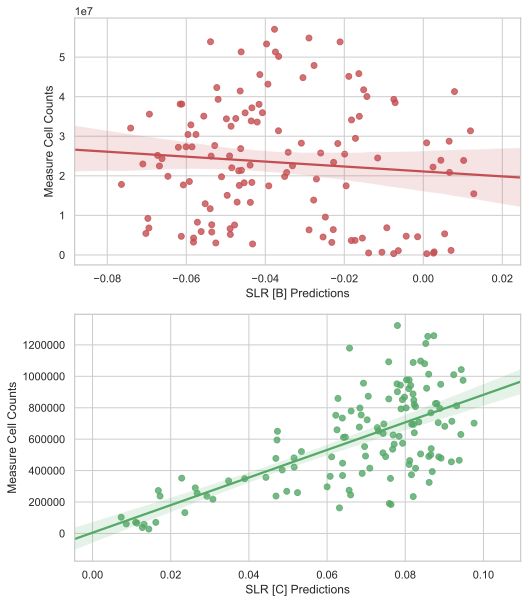

In [25]:
fs = (8,10)
fig, ax=plt.subplots(nrows=2, ncols=1, figsize=fs)
sns.regplot(data=o2, x='B_p', y='B_mean', color='r', ax=ax[0])
ax[0].set_ylabel('Measure Cell Counts')
ax[0].set_xlabel('SLR [B] Predictions')

sns.regplot(data=o2, x='C_p', y='C_mean', color='g', ax=ax[1])
ax[1].set_ylabel('Measure Cell Counts')
ax[1].set_xlabel('SLR [C] Predictions')

Text(0, 0.5, 'Measure Cell Counts')

Text(0.5, 0, 'SLR [B] Predictions')

Text(0, 0.5, 'Measure Cell Counts')

Text(0.5, 0, 'SLR [C] Predictions')

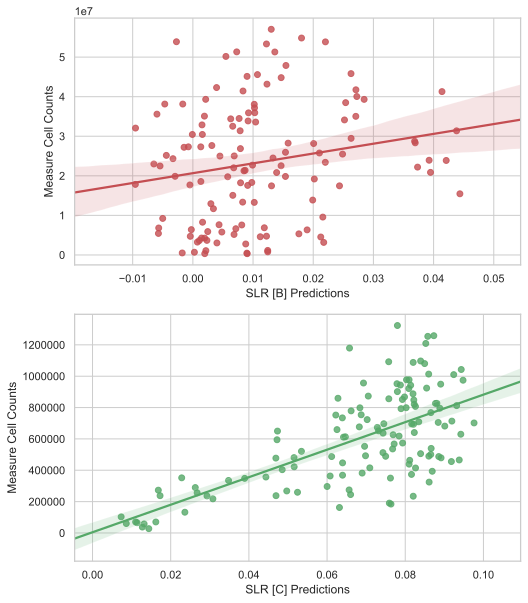

<ErrorbarContainer object of 3 artists>

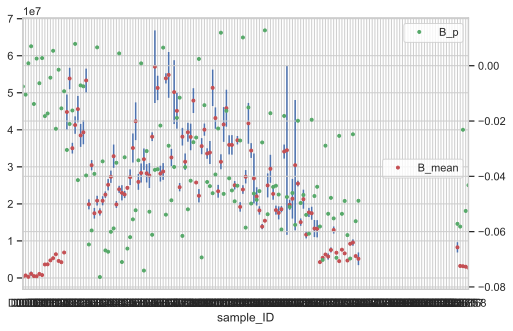

In [26]:
fig, ax=plt.subplots(figsize=(8,5))
o2.plot(y='B_mean', style='r.', ax=ax)
ax.errorbar(x=o2.index, y=o2['B_mean'], yerr=o2['B_std'], fmt='none')
ax.legend(bbox_to_anchor=(0, 0, 1, .5))

ax2 = ax.twinx()
o2.plot(y='B_p', ax=ax2, style='g.')

<ErrorbarContainer object of 3 artists>

Text(0, 0.5, 'Bacteria cell counts')

Text(0, 0.5, 'Bacteria Predicted Signal (B_p)')

<ErrorbarContainer object of 3 artists>

Text(0, 0.5, 'Chalmy cell counts')

Text(0, 0.5, 'Chlamy Predicted Signal (B_mean)')

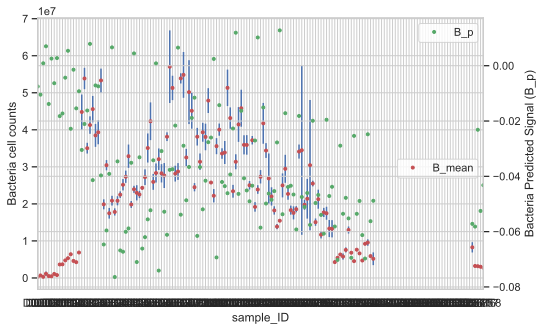

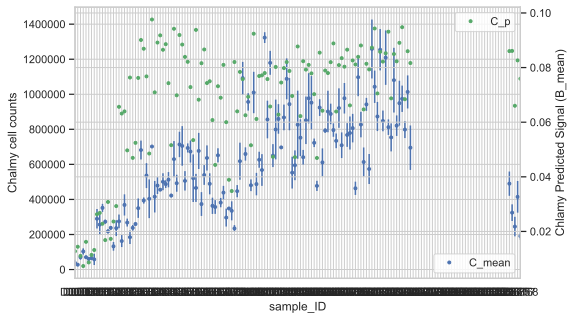

In [27]:
fig, ax=plt.subplots(figsize=(8,5))
o2.plot(y='B_mean', style='r.', ax=ax)
ax.errorbar(x=o2.index, y=o2['B_mean'], yerr=o2['B_std'], fmt='none')
ax.legend(bbox_to_anchor=(0, 0, 1, .5))
ax.set_ylabel('Bacteria cell counts')

ax2 = ax.twinx()
o2.plot(y='B_p', ax=ax2, style='g.')
ax2.set_ylabel('Bacteria Predicted Signal (B_p)')

fig, ax=plt.subplots(figsize=(8,5))
o2.plot(y='C_mean', style='b.', ax=ax)
ax.errorbar(x=o2.index, y=o2['C_mean'], yerr=o2['C_std'], fmt='none')
ax.set_ylabel('Chalmy cell counts')

ax.legend(bbox_to_anchor=(0, 0, 1, .5))

ax2 = ax.twinx()
o2.plot(y='C_p', ax=ax2, style='g.')
ax2.set_ylabel('Chlamy Predicted Signal (B_mean)')

# Apply New MODEl END

In [ ]:
# extract regressor Coefficients
def get_regr_coefficients(coeff_df, wavelength='560', and_mlr_model=False):
    
    """This function extracts the Tecan data regression coefficients and returns
    them as an array. The simple regresssion coefficient are modified for 
    application to the PBR pathlength. """
    
    if and_mlr_model==False:
        ks = coeff_df.loc[wavelength].values[:4] * 2.7
        
    # include machine learning model coefficients    
    elif and_mlr_model:
        ks1 = coeff_df.loc[wavelength].values[:4] * 2.7
        
        # mlr models are divided by the pathlength--this has to do with the
        # way the predicted values are calculated, its an algebraic manipulation
        ks2 = coeff_df.loc[wavelength].values[4:] / 2.7
        ks = np.append(ks1, ks2)
    
    return ks

In [ ]:
def apply_model(pbr_data, Ks, and_mlr_model=False):
    """This function applies the models to the PBR data and returns the complete dataframe
    and calcuated values.# IFF the model hold true, then the values obtained here should match
    those that are obtained at the the Tecan reader. At the very least the ratios should match.
    """
    
    tdf = pbr_data.copy()    
    get_params = zip(*[iter(tdf.columns)]*2)
    print(get_params)
    if and_mlr_model ==False:

        flag=0
        while flag < 8:

            # stop operation after the 8th pair of vessel values
            A680, A720 = next(get_params)
            print(A680,A720)
            # vessel number
            V = A680[-1]

            tdf['Bv%s' %V] = (Ks[1]*tdf[A720] - Ks[3]*tdf[A680]) / (Ks[1]*Ks[2] - Ks[3]*Ks[0])
            tdf['Cv%s' %V] = (Ks[0]*tdf[A720] - Ks[2]*tdf[A680]) / (Ks[0]*Ks[3] - Ks[2]*Ks[1])
            #tdf['SSv%s' %V] = tdf['Bv%s' %V] + tdf['Cv%s' %V]
            
            # predicted fraction
            #tdf['Bf_v%s' %V] =  tdf['Bv%s' %V] / tdf['SSv%s' %V]
            #tdf['Cf_v%s' %V] =   tdf['Cv%s' %V] / tdf['SSv%s' %V]
            
            # ratio is not very informative
            #tdf['B/C_v%s' %V] = tdf['Bv%s' %V] / tdf['Cv%s' %V]

            flag+=1
  
    return tdf
        

# Apply Model to PBR Date Extracted DAta

In [ ]:
path='/home/rdmtinez/Desktop/MScThesis/data_o/pbr/pbr_exp_preprocessed'
pbxdf2 = pd.read_csv(pjoin(path,'pbr_matching_dates_to_tecan_x2.csv'),index_col=0)
pbxdf3 = pd.read_csv(pjoin(path,'pbr_matching_dates_to_tecan_x3.csv'),index_col=0)

In [ ]:
model_loc = """/home/rdmtinez/Documents/B-IT MS Program/Masters Thesis/data_o/calibration/community_calibration/created_models"""
a680_a720 = pd.read_csv(model_loc+'/a680_a720_coefficients.csv',index_col=0)

In [ ]:

a680_a720.loc['560']
# get specific coefficients

Ks = get_regr_coefficients(a680_a720, '560', False)

# Ks Adapted to to the PBR pathlength
Ks



In [ ]:
npbxdf2 = pbxdf2
npbxdf2 = apply_model(npbxdf2, Ks, and_mlr_model=False)

In [ ]:
npbxdf3 = pbxdf3
npbxdf3 = apply_model(npbxdf3, Ks, and_mlr_model=False)

In [ ]:
path = '/home/rdmtinez/Desktop/MScThesis/data_o/pbr/pbr_modeled_output_data'
npbxdf2.to_csv(pjoin(path,'pbr_w_tec_dates_x2.csv'))
npbxdf3.to_csv(pjoin(path,'pbr_w_tec_dates_x3.csv'))

In [ ]:
npbxdf2.head()
npbxdf3.head()